In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
tic = 40404470

f_Ny = 323.7577400015701, f_R = 0.017787909455610686
10
Found 11 frequencies
7 unique frequencies


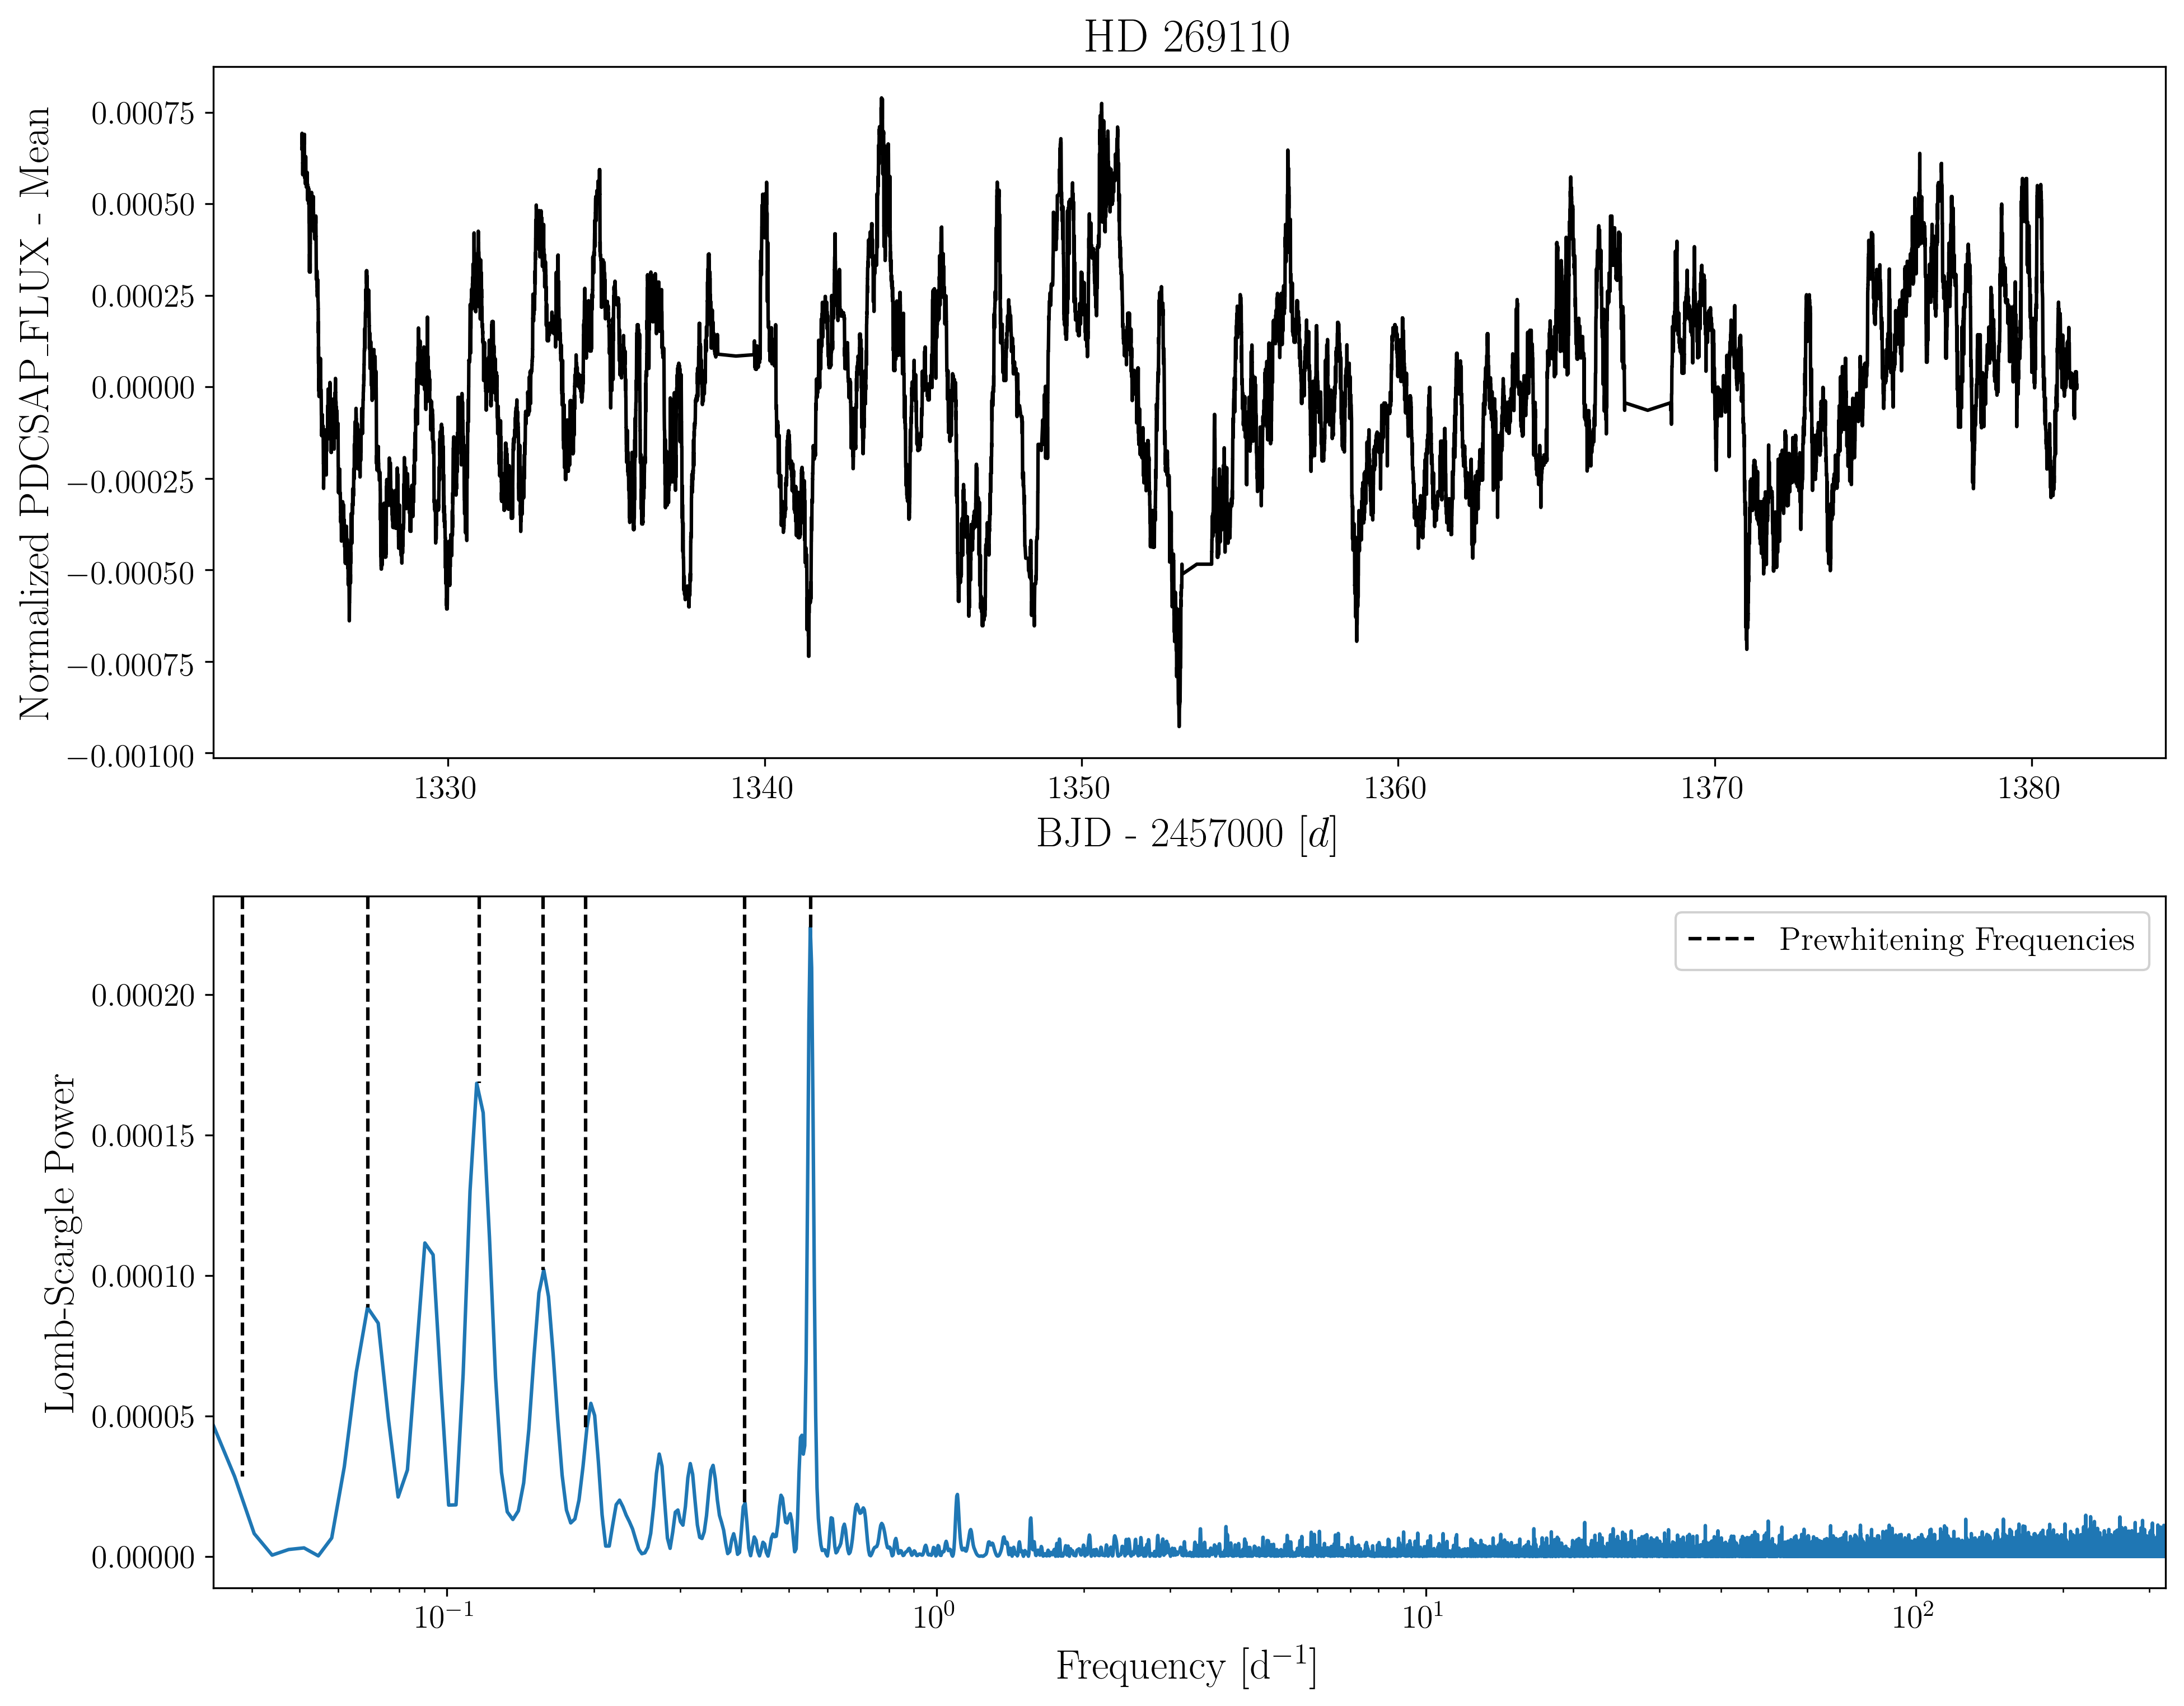

In [3]:
fig, ax = plt.subplots(2, figsize=(15,12),dpi=300)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux']-np.mean(lc_smooth['Flux']),c='k')
ax[0].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX - Mean')


time, flux, err = lc['Time'], lc['Flux'], lc['Err']
pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)

ax[1].plot(freq, power)

ax[1].set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax[1].get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='k',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='k',ls='--')
    
#plt.plot([1.33479,1.33479],[ylim[1],power[np.argmin(np.abs(freq-1.33479))]],c='C3',ls='--',label='$f=1.33479$ day$^{-1}$ and harmonics')
#plt.plot([2.670179,2.670179],[ylim[1],power[np.argmin(np.abs(freq-2.670179))]],c='C3',ls='--')
#plt.plot([4.00557,4.00557],[ylim[1],power[np.argmin(np.abs(freq-4.00557))]],c='C3',ls='--')

ax[1].set(ylim=ylim)
ax[1].legend(fontsize=14, framealpha=0.9)
    
for a in ax:
    a.xaxis.label.set_size(18)
    a.yaxis.label.set_size(18)
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

ax[0].set_title('HD 269110',fontsize=20)
plt.savefig('../plots/HD269110_lcperiod.pdf')

In [4]:
harmonic_search(good_fs)

array([[0.06899622, 0.03827322, 0.03827322, 0.03827322],
       [0.55347685, 0.11644097, 0.15753531, 0.19233848],
       [8.        , 3.        , 4.        , 5.        ]])

In [5]:
combo_search(good_fs)

array([], shape=(3, 0), dtype=float64)

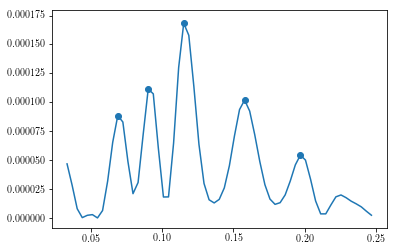

In [6]:
lowf = freq[freq <= 0.25]
lowp = power[freq <= 0.25]
plt.plot(lowf,lowp)
fs, ps = peak_finder(lowf,lowp,5,width=3)
plt.scatter(fs, ps)

In [7]:
np.mean(np.diff(np.sort(fs)))

0.03201823702009923

In [8]:
numax_obs = lowf[np.argmax(lowp)]
deltanu_obs = np.mean(np.diff(np.sort(fs)))
numax_sol = 3050.0 * 0.09 #inverse days
delnu_sol = 134.9 * 0.09 
T_sol = 5778.0

def astero_M(numax,deltanu,logT):
    #asteroseismic mass from Kjeldsen & Bedding 1995
    fac1 = np.power(numax/numax_sol,3.0)
    fac2 = np.power(delnu_sol/deltanu_obs,4.0)
    fac3 = np.power(np.power(10.0,logT)/T_sol,1.5)
    return fac1*fac2*fac3

In [9]:
astero_M(numax_obs,deltanu_obs,3.750)

1.4655949510762947